In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas_datareader as data
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime
from datetime import time
from pandas.tseries.frequencies import to_offset
import tensorflow as tf
from sklearn import metrics

In [41]:
# Choosing a period which we want to analyze for training and validating
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2022, 6, 1)
# end = datetime.date.today()

# BA boeing company, data from Yahoo finanse
stock_d = data.DataReader('XOM', 'yahoo', start, end)

# # week opening
# def week_open(array_like):
#     return array_like[0]

# # week closing
# def week_close(array_like):
#     return array_like[-1]

# # Aplied logic: that opening day is Monday, Closing day is Friday
# logic = {
#                         # Open - first day (Monday) opening value
#                         'Open': week_open, 
#                         # High - max value of the period
#                          'High': 'max',
#                         # Low - min value of the period
#                          'Low': 'min',
#                         #  Close - last day closing value (Friday)
#                          'Close': week_close,
#                          #  Adj Close - last day closing value (Friday)
#                          'Adj Close': week_close,
#                         #  Volume - sum of period Volume values
#                          'Volume': 'sum'}

# # Converting daily data to weekly with aplied logic
# stock_w = stock_d.resample('W').apply(logic) 
# stock_w.index -= to_offset('6D')


df = stock_d[['Open', 'High', 'Low',  'Close', 'Adj Close']] #'Close',

In [42]:
print(df.tail(5))

                 Open       High        Low      Close  Adj Close
Date                                                             
2022-05-25  94.580002  96.529999  94.470001  96.300003  96.300003
2022-05-26  96.599998  97.430000  96.199997  96.639999  96.639999
2022-05-27  95.949997  97.930000  95.300003  97.589996  97.589996
2022-05-31  98.559998  99.779999  95.709999  96.000000  96.000000
2022-06-01  97.019997  98.709999  96.620003  97.839996  97.839996


In [43]:
x = 1
validate = df[['Open', 'High', 'Low',  'Close', 'Adj Close']].tail(x)
df.drop(df.tail(x).index,inplace=True)

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
df = df.reset_index()
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.shape)
print(train_dates.tail(15)) #Check last few dates. 

(5639,)
5624   2022-05-10
5625   2022-05-11
5626   2022-05-12
5627   2022-05-13
5628   2022-05-16
5629   2022-05-17
5630   2022-05-18
5631   2022-05-19
5632   2022-05-20
5633   2022-05-23
5634   2022-05-24
5635   2022-05-25
5636   2022-05-26
5637   2022-05-27
5638   2022-05-31
Name: Date, dtype: datetime64[ns]


In [45]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_data = X_scaler.fit_transform(df[['Open', 'High', 'Low', 'Adj Close', 'Close']])
Y_data = Y_scaler.fit_transform(df[['Close']]) 

In [46]:
def custom_ts_multi_data_prep(df, target, start, end, n_past, n_future):
    X = []
    y = []
    start = start + n_past
    if end is None:
        end = len(df) - n_future
    for i in range(start, end):
        indices = range(i-n_past, i)
        X.append(df[indices])
        indicey = range(i+1, i+1+n_future)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

In [47]:
n_past = 52
n_future = 1
TRAIN_SPLIT = len(df)-300
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, n_past, n_future)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, n_past, n_future) 

In [48]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target\n')
print (y_train[0]) 

Multiple window of past history

[[-1.45354777 -1.44733531 -1.46939667 -1.57908664 -1.4838585 ]
 [-1.50841788 -1.51321787 -1.5050471  -1.60108958 -1.52255228]
 [-1.49227961 -1.42162505 -1.47101715 -1.53966435 -1.41453216]
 [-1.42449889 -1.31717709 -1.40943914 -1.47824036 -1.30651204]
 [-1.28732362 -1.30592885 -1.31059024 -1.48190755 -1.312961  ]
 [-1.33251077 -1.34770803 -1.32193356 -1.49932624 -1.34359358]
 [-1.34380755 -1.33163912 -1.32031309 -1.49565927 -1.33714461]
 [-1.35671817 -1.3541356  -1.34137925 -1.50299332 -1.35004254]
 [-1.35026286 -1.31235642 -1.33327688 -1.47457305 -1.30006308]
 [-1.29862041 -1.32521155 -1.33651782 -1.49932624 -1.34359358]
 [-1.36962878 -1.32521155 -1.35272256 -1.48465769 -1.31779773]
 [-1.33089694 -1.3155702  -1.31869261 -1.47273951 -1.2968386 ]
 [-1.30668954 -1.33163912 -1.34462019 -1.50024273 -1.34520582]
 [-1.33735225 -1.33324601 -1.32841546 -1.48099016 -1.31134876]
 [-1.30023423 -1.30432196 -1.33651782 -1.49199185 -1.33069565]
 [-1.33735225 -1.30914

In [49]:
batch_size = 64
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=n_future),
 ])
model.compile(optimizer='adam', loss='mse') # metrics='mae
model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 52, 128)          35840     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 52, 20)            2580      
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               13568     
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 20)                1300      
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [51]:
# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2)) #DELETE
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.3))
# model.add(Dense(n_future))

# model.compile(optimizer='adam', loss='mse', metrics='mae')
# model.summary()

In [52]:

model_path = 'LSTM_multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5) #,  mode='min'
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True,  verbose=0) #mode='min',
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=15,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/15
100/100 [==============================] - 18s 105ms/step - loss: 0.2495 - val_loss: 0.1348
Epoch 2/15
100/100 [==============================] - 10s 99ms/step - loss: 0.1245 - val_loss: 0.0585
Epoch 3/15
100/100 [==============================] - 10s 102ms/step - loss: 0.0890 - val_loss: 0.0563
Epoch 4/15
100/100 [==============================] - 10s 101ms/step - loss: 0.0896 - val_loss: 0.1124
Epoch 5/15
100/100 [==============================] - 10s 97ms/step - loss: 0.0942 - val_loss: 0.1270
Epoch 6/15
100/100 [==============================] - 10s 98ms/step - loss: 0.0653 - val_loss: 0.2550
Epoch 7/15
100/100 [==============================] - 10s 104ms/step - loss: 0.0584 - val_loss: 0.0826
Epoch 8/15
100/100 [==============================] - 10s 104ms/step - loss: 0.0627 - val_loss: 0.0309
Epoch 9/15
100/100 [==============================] - 10s 100ms/step - loss: 0.0672 - val_loss: 0.0807
Epoch 10/15
100/100 [==============================] - 10s 100ms/step - loss

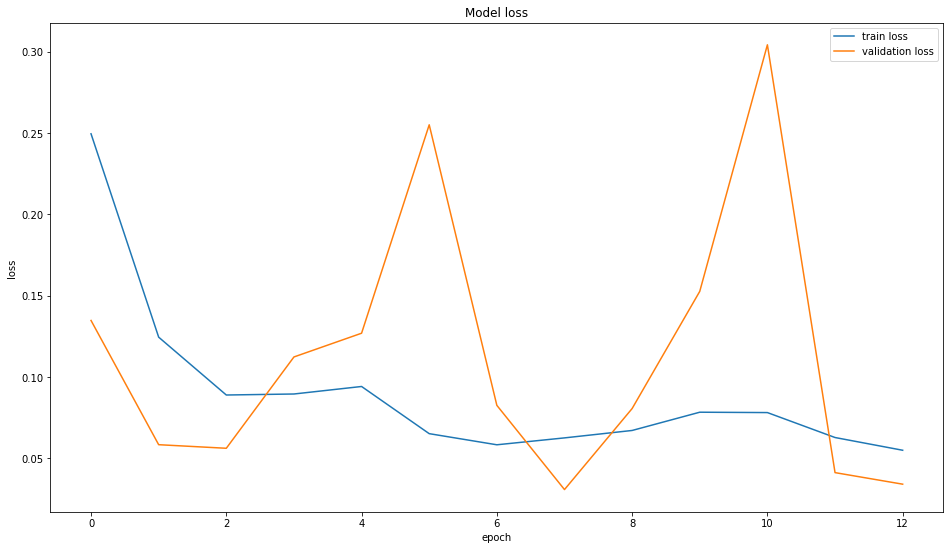

In [53]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

### Forecasting is completely unavailable and must be only estimated with the help of what has already happened.

In [54]:
data_val = X_scaler.fit_transform(df[['Open', 'High', 'Low', 'Adj Close', 'Close']].tail(52))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

1/1 [==============================] - 2s 2s/step


array([[98.39791]], dtype=float32)

In [55]:
validate['Close']

Date
2022-06-01    97.839996
Name: Close, dtype: float64

In [56]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 


timeseries_evaluation_metrics_func(validate['Close'], pred_Inverse[0])

Evaluation metric results:-
MSE is : 0.3112688502878882
MAE is : 0.5579147338867188
RMSE is : 0.5579147338867188
MAPE is : 0.5702317608025649
R2 is : nan



c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
